In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time 

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
sns.set(font_scale=1.5)

In [7]:
data = pd.read_csv(r"C:\Users\Amit Vikram Raj\#Self_Learning\#ProjectPro\Projects\Regression-Models-for-House-Price-Prediction\input\resd_features.csv")

In [8]:
data.head()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
0,-1.082437,1.0,0,1,0,0,1,0,3.9
1,-0.331565,2.0,0,1,0,0,1,0,6.5
2,-0.025358,3.0,0,1,0,0,1,0,7.4
3,0.318126,3.0,0,1,0,0,1,0,8.9
4,-0.414108,2.0,0,1,0,0,0,0,7.4


In [9]:
# Features - traget separation
X = data.iloc[:,:-1]
y = data["price"]


## MLPRegression with scikit-learn

In [10]:
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X.values, y.values, test_size=.3, random_state=rs)
        
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_)
    print("Best CV score:", abs(est_cv.best_score_))
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test)
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred), 
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


In [11]:
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) 
    
    residue_train = y_train.values.reshape(-1,1)-estimator.predict(X_train.values).reshape(-1,1)
    residue_test = y_test.values.reshape(-1,1)-estimator.predict(X_test.values).reshape(-1,1)                                                     
               
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")

    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

In [12]:
rs=10

mlpReg = MLPRegressor(activation='relu', solver='adam',
                      learning_rate_init=0.001,  max_iter=500,  
                      early_stopping=True, validation_fraction=0.1, 
                      n_iter_no_change=30, tol=1.e-4, random_state=rs)

pg = {"hidden_layer_sizes":[(10,), (20,), (10, 5), (20, 10)], 
      "learning_rate":['constant', 'invscaling', 'adaptive'],
      "alpha":np.logspace(-3,3,5),
      "batch_size":[8,16,32,64]
     }

mlpReg_cv = gridSearchReport( mlpReg, X, y, pg, cv=5, rs=rs )

Best parameters: {'alpha': 0.03162277660168379, 'batch_size': 8, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant'}
Best CV score: 11.545782007333708
MSE, R2 train: 9.162920867549065 ,  0.7734325969350029
MSE, R2 test: 4.656067810518021 ,  0.758746019833827
Elapsed time: 63.25 s , 1.05 min


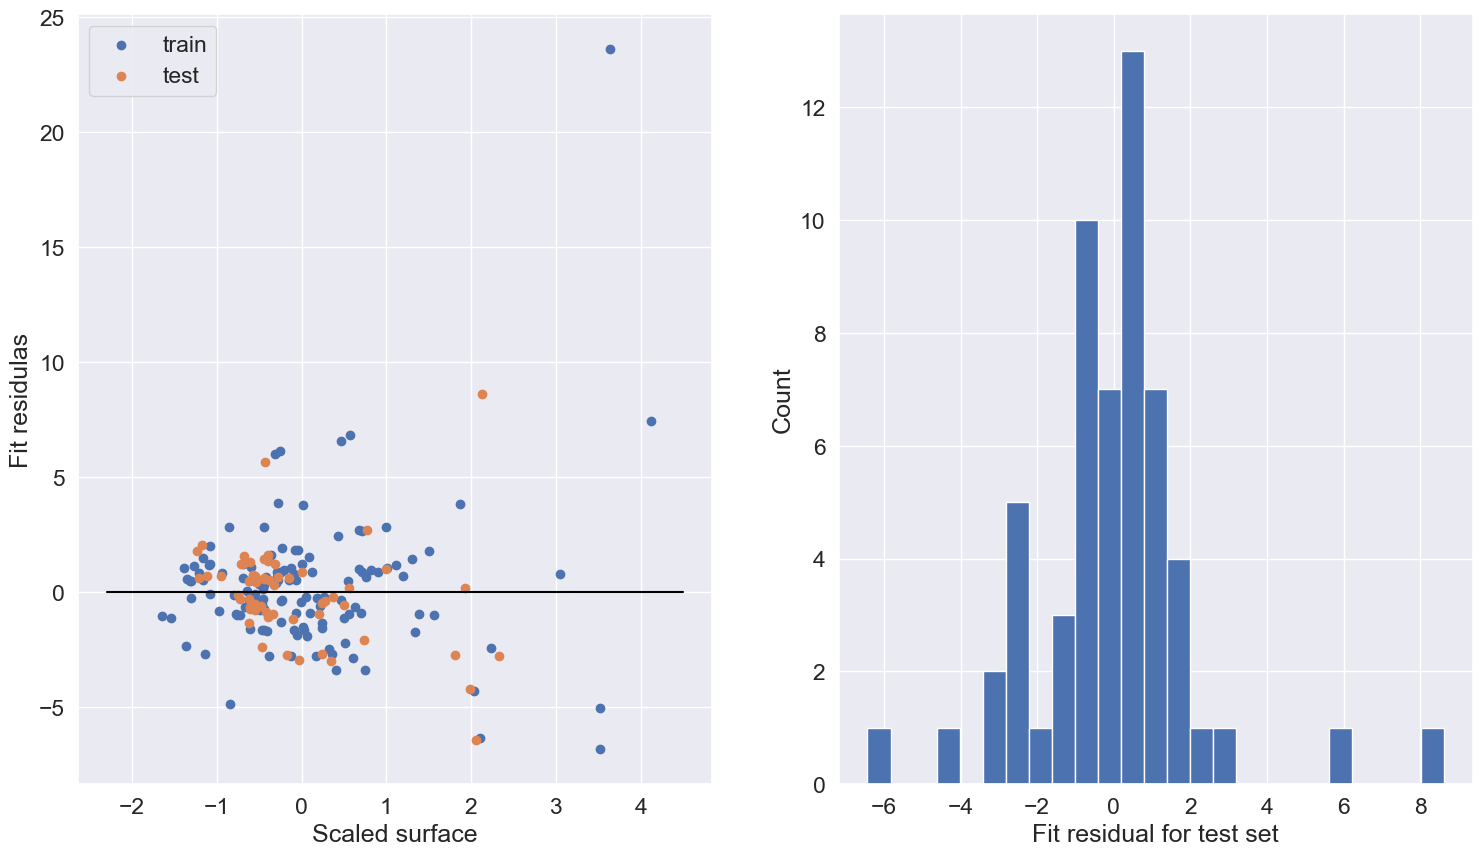

mean residuals: -0.05 
std: 2.16


In [13]:
plotResidue(mlpReg_cv, X, y, rs=rs)

In [14]:
def plot_real_pred(est, X, y, rs):
    """
    Plots the real price vs. predicted price
    Params:
        est: the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X.values, y.values, test_size=.3, random_state=rs)
    
    fig = plt.figure(figsize=(7,7))
    plt.scatter(y_test, est.predict(X_test))
    plt.plot([ min(y_test), max(y_test)], [min(y_test), max(y_test)], c="k")
    plt.xlabel("Real price")
    plt.ylabel("Predicted price")
    plt.show()
    

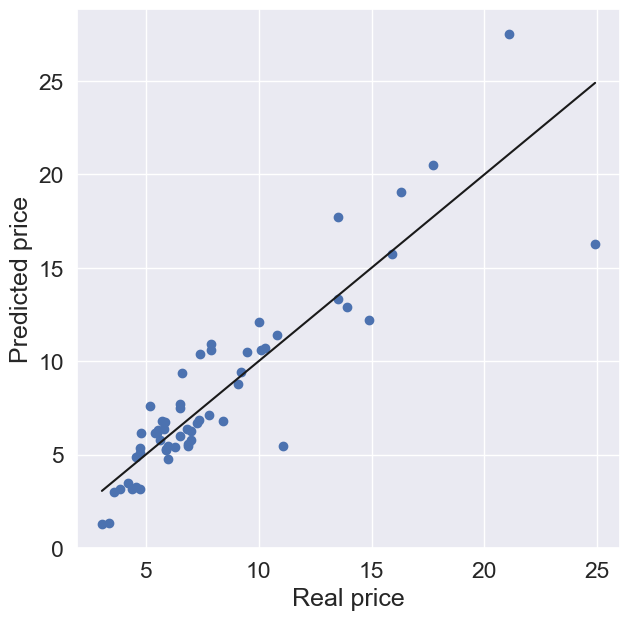

In [15]:
plot_real_pred(mlpReg_cv, X, y, rs)

## Regression with Tensor Flow

In [16]:
# Price min-max normalization to be used with tanh activation
R = np.max(y)-np.min(y)
y0 = np.min(y)
y_scaled = 2*(y-y0)/(R)-1

In [17]:
def y2price(y, R):
    """
    Convert the scaled price to normal price
    Args:
    y: list, serie, array
        scaled price
    R: float
        scale factor
    """
    return y #R*(y+1)/2.+y0

In [18]:
rs=13
X_train, X_test, y_train, y_test = train_test_split(X.values, y_scaled.values, 
                                                    test_size=.3, 
                                                    random_state=rs)

In [19]:
# Define a function to build a TF model
def tf_template():

    model = tf.keras.models.Sequential()

    # dense hidden layer
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # output layer
    model.add(tf.keras.layers.Dense(1, activation='tanh'))

    return model

In [20]:
# Building a model
tf_model = tf_template()

# Compiling the model
tf_model.compile(loss='mse', 
                 optimizer=tf.keras.optimizers.Adam(), 
                 metrics=['mse', 'mae'])
 
callback=tf.keras.callbacks.EarlyStopping(
                                    monitor="val_loss",
                                    min_delta=1.e-4,
                                    patience=20,
                                    verbose=0,
                                    mode="auto",
                                    baseline=None,
                                    restore_best_weights=True
                                )    

# Training the model
n_epochs = 500
batch_size = 8
tf_model.fit(X_train, y_train, callbacks=[callback],
              epochs=n_epochs, batch_size=batch_size, 
              validation_data=(X_test, y_test),
              verbose=0, shuffle=True)

In [21]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                180       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [22]:
tf_model.history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

In [23]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(np.arange(len(loss)), loss, label='Training')
    ax[0].plot(np.arange(len(val_loss)), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(len(acc)), acc, label='Training')
    ax[1].plot(np.arange(len(acc)), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')


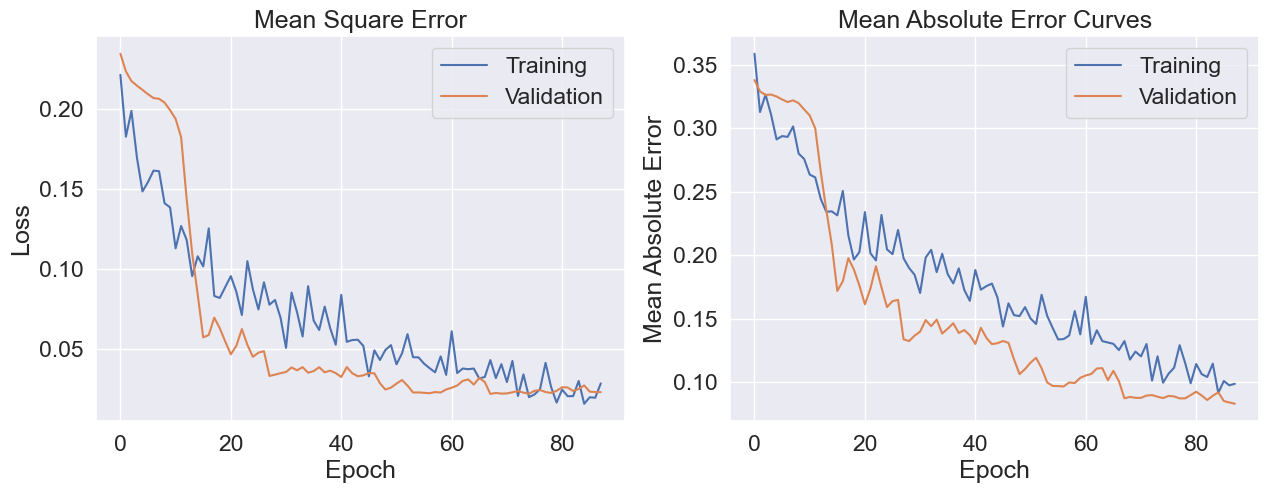

In [24]:
# plot the training history
plot_model_history(tf_model.history)

2/2 [==============================] - 0s 1ms/step


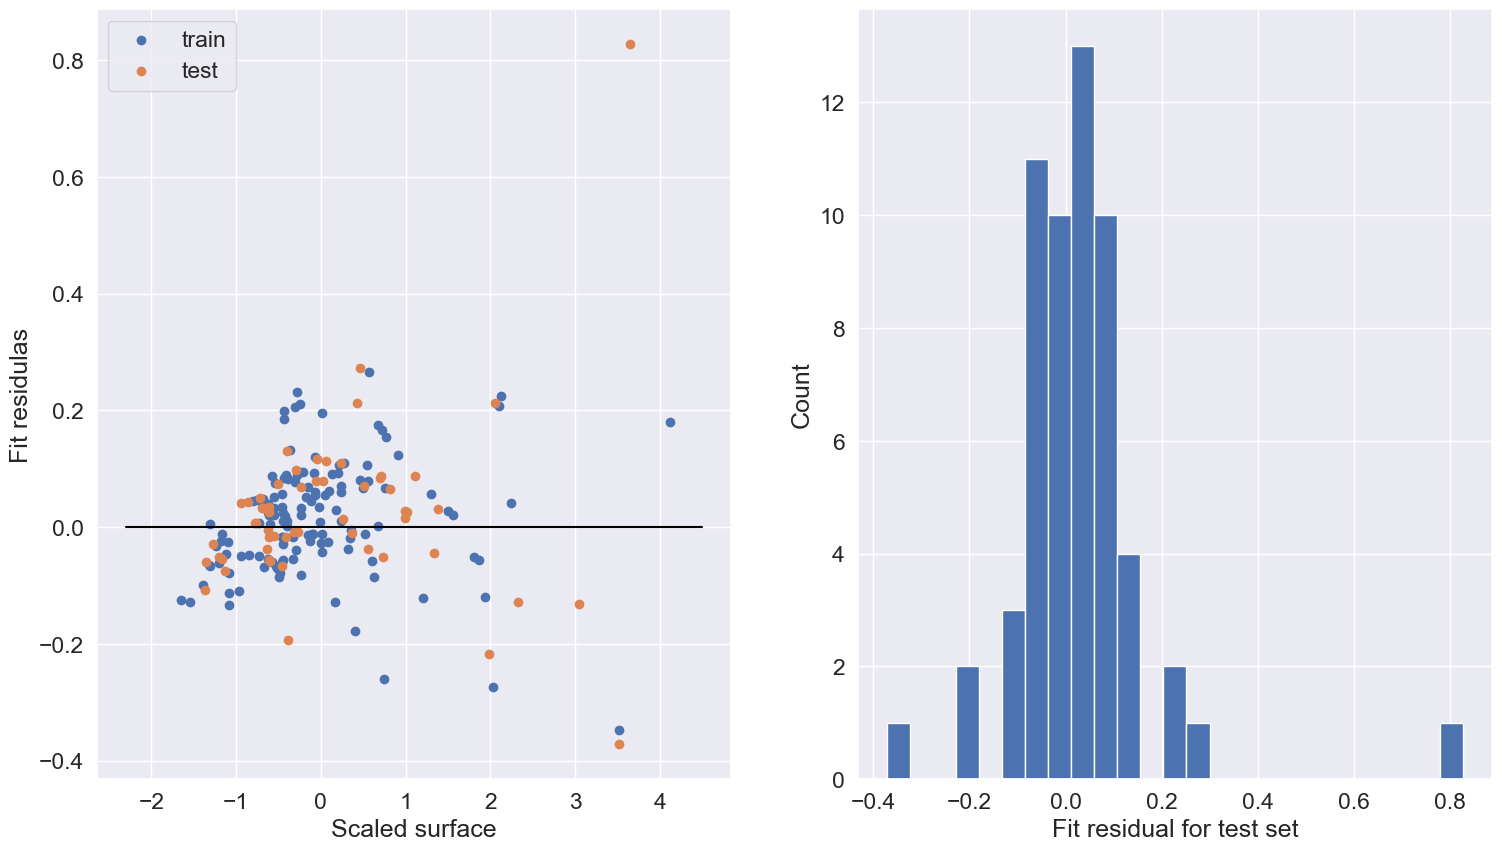

mean residuals: 0.02 
std: 0.15


In [25]:
plotResidue(tf_model, X, y_scaled, rs=rs)

2/2 [==============================] - 0s 2ms/step


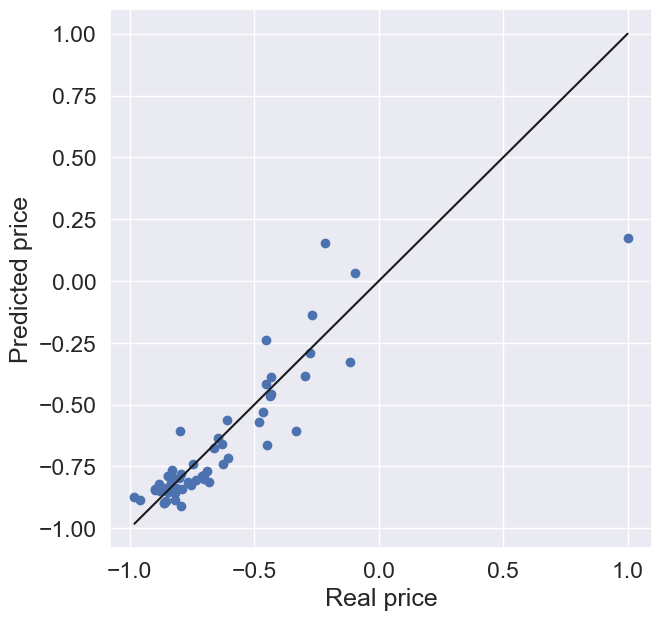

In [26]:
plot_real_pred(tf_model, X, y_scaled, rs)

In [27]:
y_train_pred = tf_model.predict(X_train)
(r2_score( y2price(y_train, R), y2price(y_train_pred, R)), 
mean_squared_error(y2price(y_train, R), y2price(y_train_pred, R)),
mean_absolute_error(y2price(y_train, R), y2price(y_train_pred, R)) )

5/5 [==============================] - 0s 1ms/step


(0.8239943376070541, 0.009931671787577468, 0.0757162635292812)

In [28]:
y_pred = tf_model.predict(X_test)
(r2_score(y2price(y_test, R), y2price(y_pred, R)), 
mean_squared_error(y2price(y_test, R), y2price(y_pred, R)),
mean_absolute_error(y2price(y_test, R), y2price(y_pred, R)) )

2/2 [==============================] - 0s 3ms/step


(0.7669346735766077, 0.022196548401406807, 0.08740229543310711)